# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In [1]:
import tensorflow as tf
import numpy as np
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import cv2 as cv2
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.contrib.layers import flatten
# Visualizations will be shown in the notebook.
%matplotlib inline
sns.set_style("white")

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './train.p'
validation_file = './valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [61]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (34799, 32, 32, 3)
Number of classes = 43


# Visualize dataset
I implemented two functions, show_random() and show_class().  
By looking at the samples, I can assume that the data already includes augmented samples.

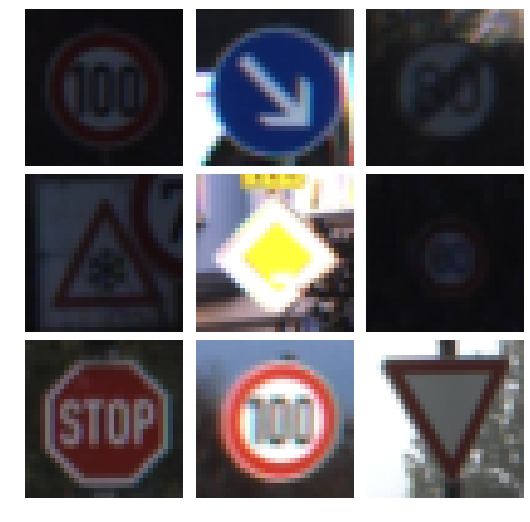

In [4]:
# show random image from train set
def show_random(x, num=1, col=3):   
    '''
    x: (None, width, height, channel) numpy array
    '''
    plt.figure(figsize=(col**2, col*int(np.ceil(num/col))))
    gs1 = gridspec.GridSpec(int(np.ceil(num/col)), col)
    gs1.update(wspace=0.05, hspace=0.05)
    for i in range(num):
        img = x[np.random.randint(0, x.shape[0], 1)].squeeze()
        plt.subplot(gs1[int(i)])
        plt.axis('off')        
        plt.imshow(img)
show_random(X_train, 9)

# Observation
30 samples from training set. We can see various augmentations have already been applied.

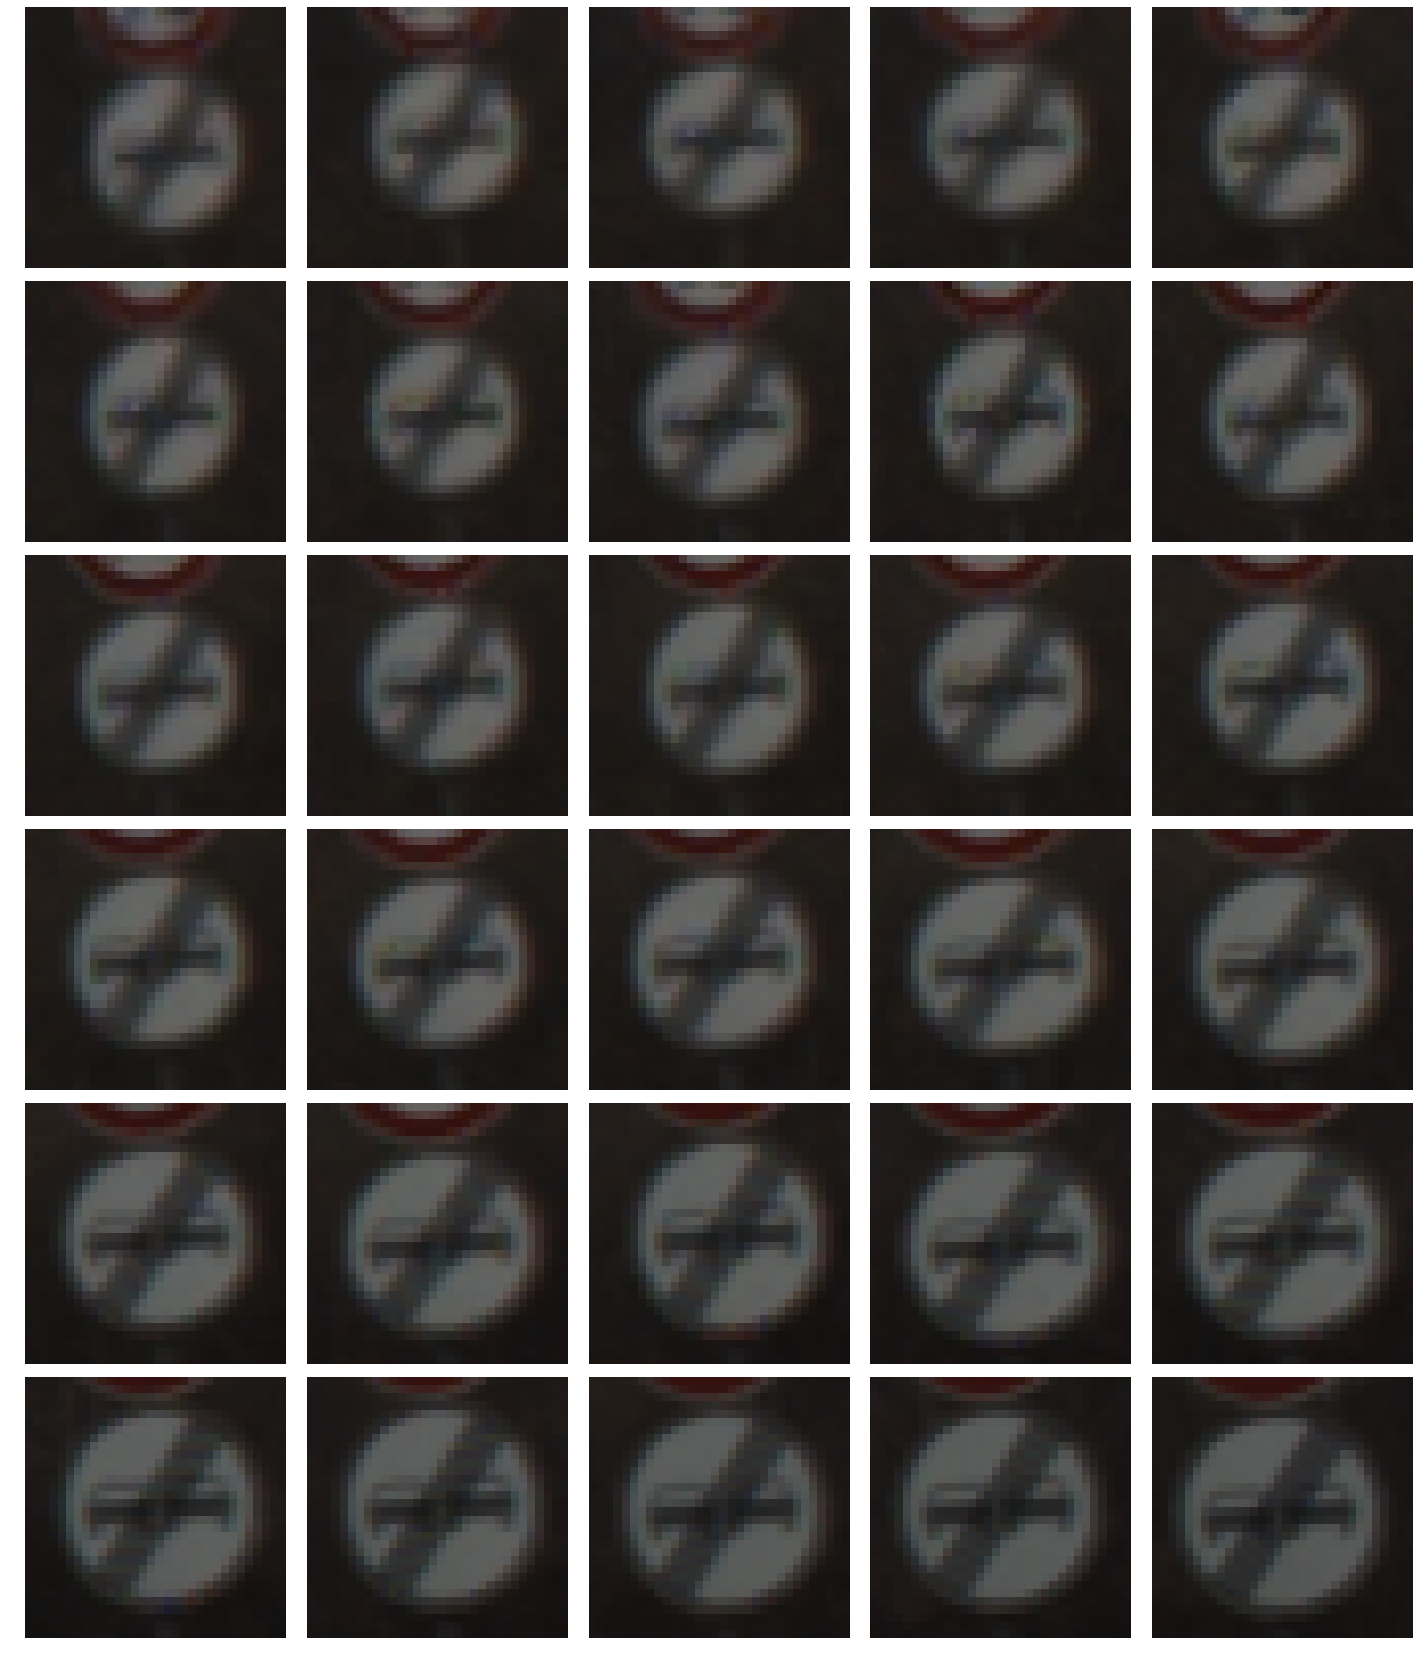

In [5]:
def show_all(x, col=5):
    num = x.shape[0]
    plt.figure(figsize=(col**2, col*int(np.ceil(num/col))))
    gs1 = gridspec.GridSpec(int(np.ceil(num/col)), col)
    gs1.update(wspace=0.05, hspace=0.05)
    for i in range(num):        
        img = x[i].squeeze()
        plt.subplot(gs1[int(i)])
        plt.axis('off')        
        plt.imshow(img)
show_all(X_train[:30])

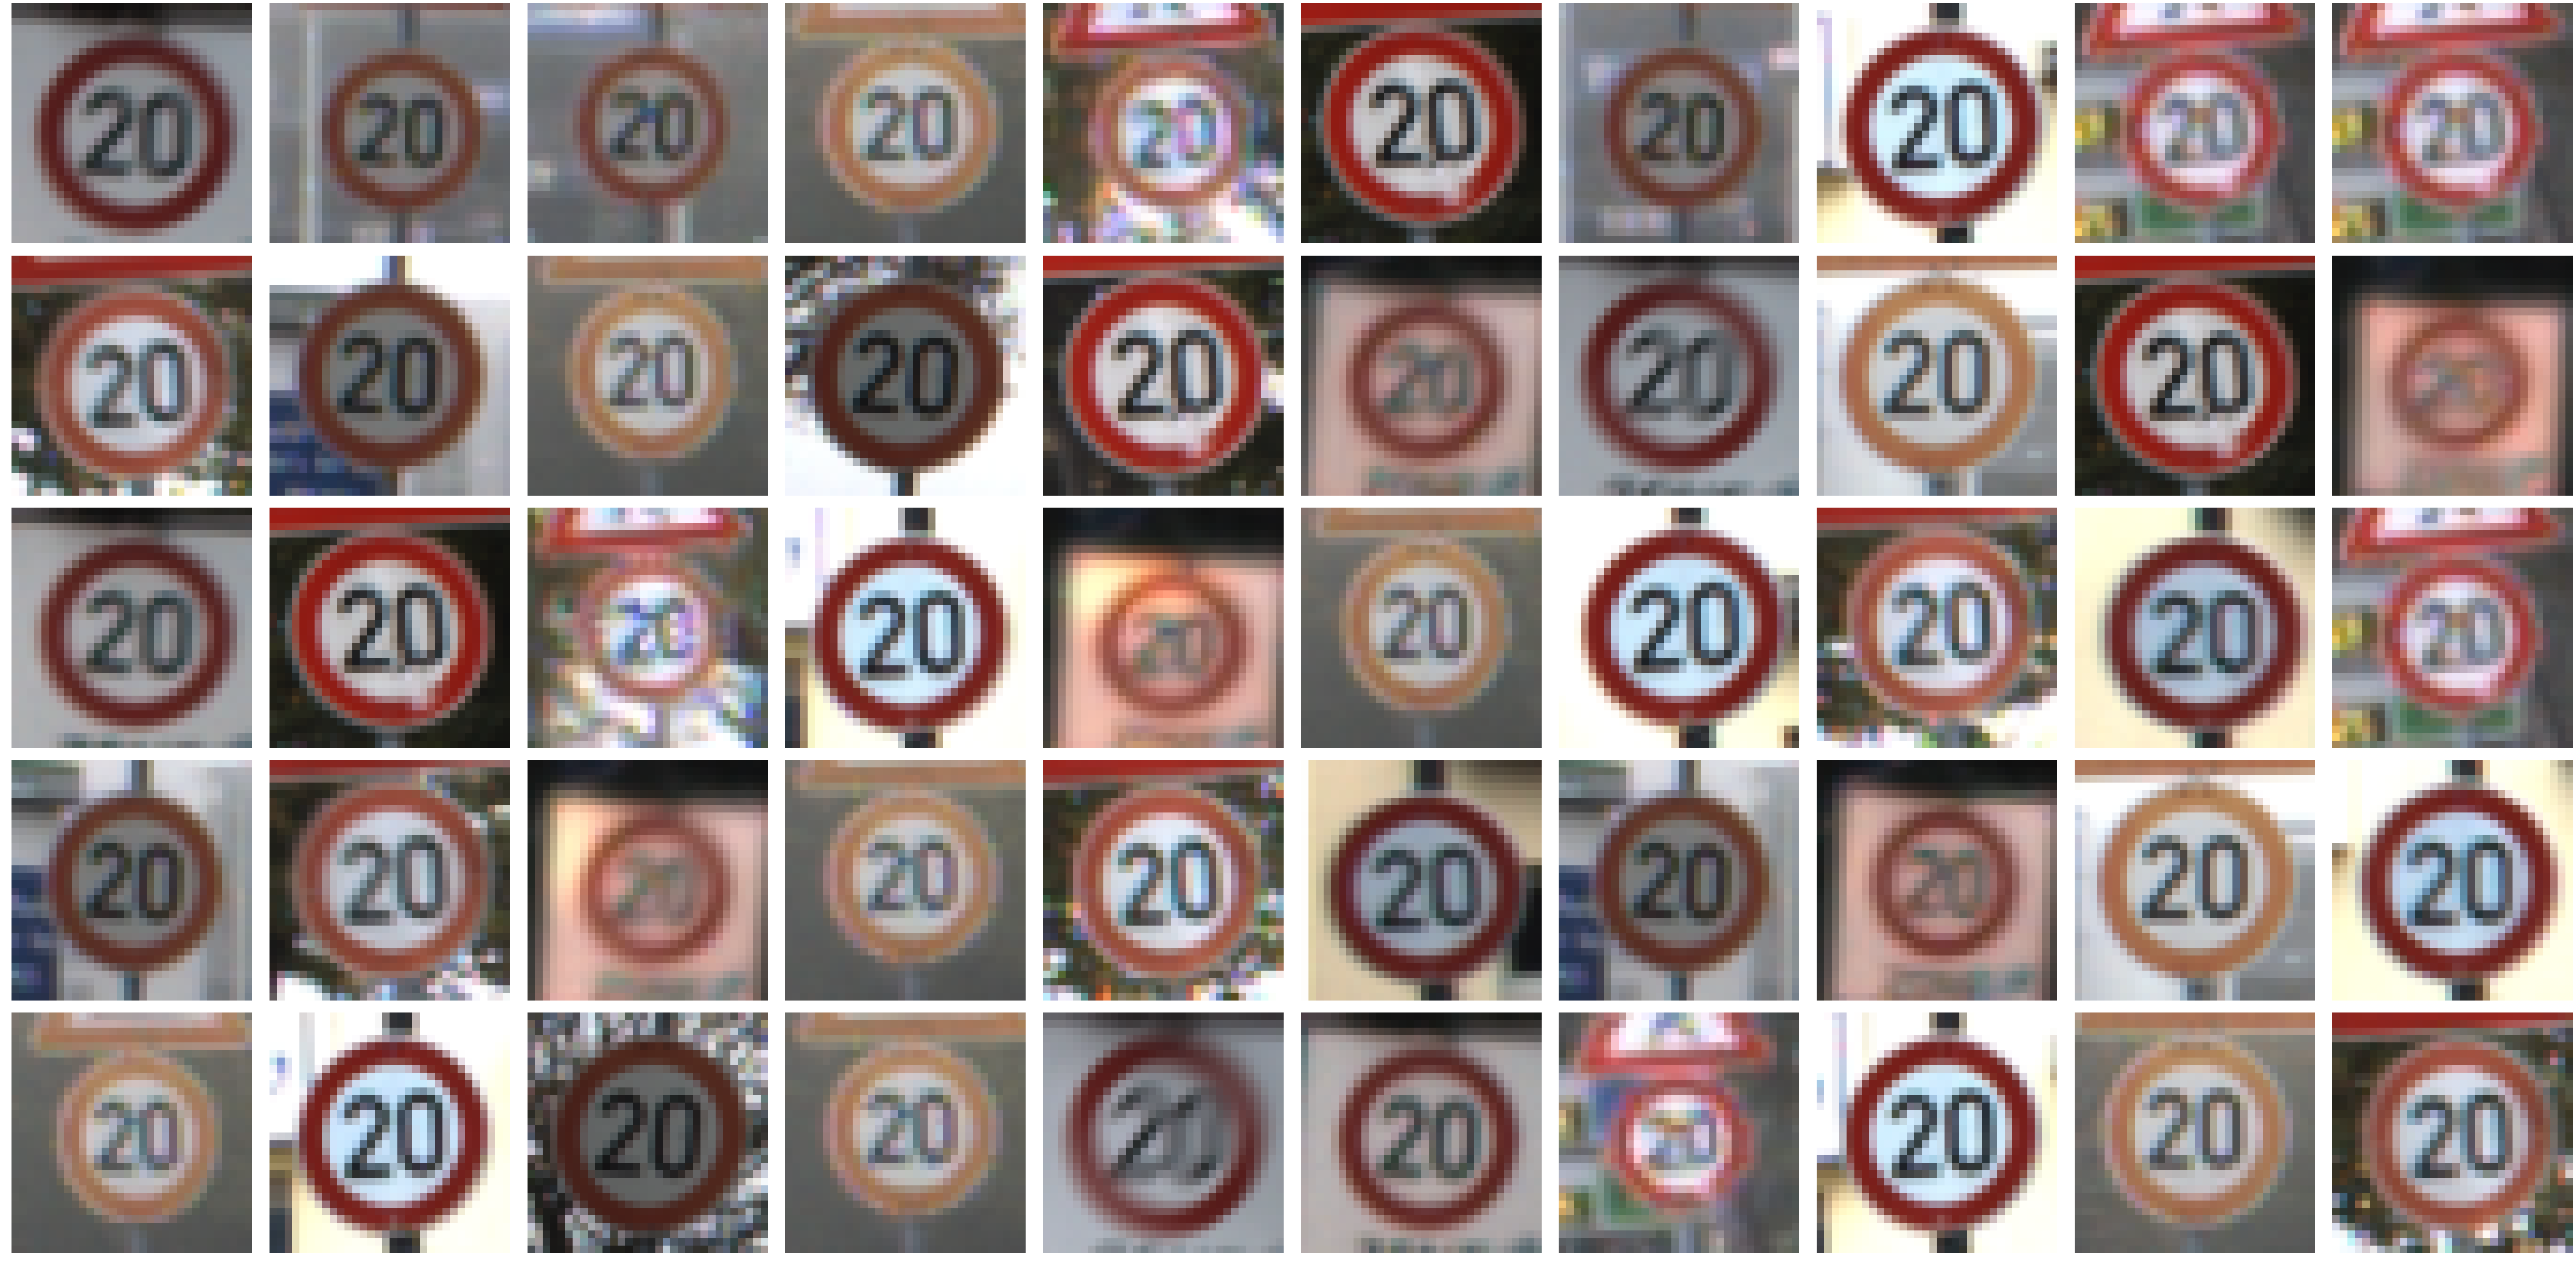

In [6]:
# show samples from certain class
def show_class(x, y, index, num=5):
    '''
    index: class index
    num: number of samples to display
    '''
    grp = x[y==index]
    show_random(grp, num, col=10)
show_class(X_train, y_train, 0, 50)

# Data distribution
The data set is skewed, and three data set (i.e. train, valid, test) seems to follow similar distribution pattern.  

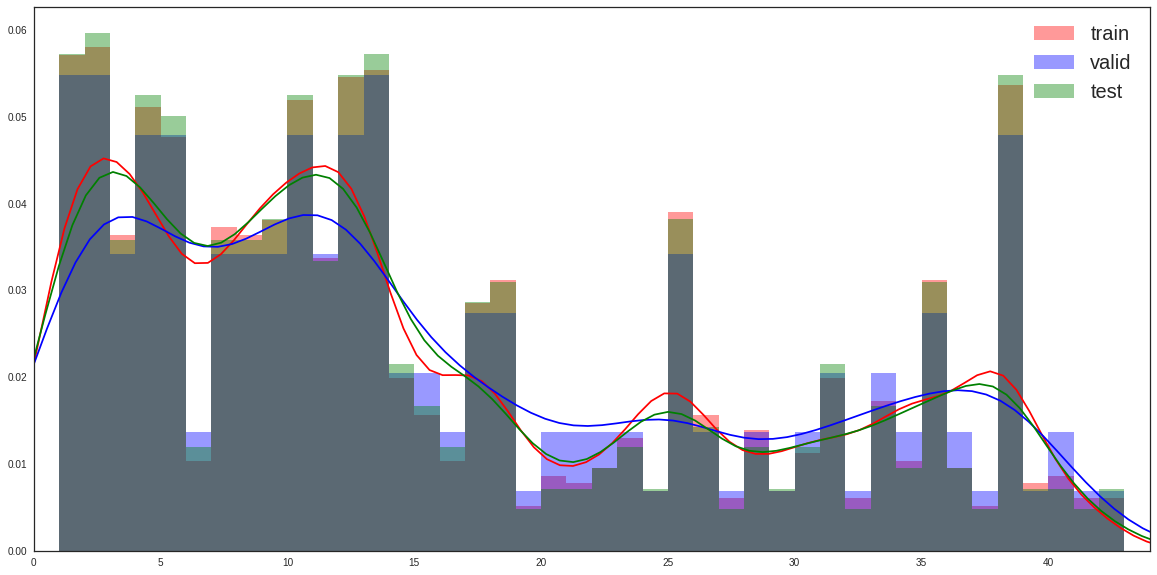

In [7]:
# class distribution of training, validation, test sets
fig, ax = plt.subplots(figsize=(20,10))
bins = np.arange(1,44)
sns.distplot(y_train, color='r', ax=ax, bins= bins, label='train')
sns.distplot(y_valid, color='b', ax=ax, bins= bins, label='valid')
sns.distplot(y_test, color='g', ax=ax, bins= bins, label='test')
plt.xlim((0,44))
plt.legend(fontsize=20)

## The ordering of data. It needs to be shuffled.

In [8]:
print(y_train[:100])

[41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41]


----

## Step 2: Design and Test a Model Architecture

The LeNet setting from lecture will give me 0.89, and minimum accuracy for submission is 0.93.

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

I wrote proprocess() which normalizes dataset, and can do optional flags to apply histogram equalization, adaptive histogram equalization, image threshold.

In [9]:
def preprocess(imageset, gray=True, equal=False, thresh=False, adaeq=False):
    '''
    imageset is numpy array (N, width, height, 3)
    1) apply grayscale 
    2) normalize
    '''
    result = []
    if gray:
        for img in imageset:
            cvimg = img.astype(np.uint8)
            cvimg = cv2.cvtColor(cvimg, cv2.COLOR_RGB2GRAY)
            if equal:
                cv2.equalizeHist(cvimg, cvimg)
            if adaeq:
                # create a CLAHE object (Arguments are optional).
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
                cvimg = clahe.apply(cvimg)
            if thresh:       
                cvimg = cv2.adaptiveThreshold(cvimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                              cv2.THRESH_BINARY,11,2)
            result.append(cvimg)        
    else:
        result = imageset
    result = np.array(result)            
    result = (result - 128.) / 128.
    if gray:
        result = result[..., None]
    return result

In [10]:
def get_random_image(imageset, num=5):
    ix = np.random.choice(imageset.shape[0], 5, replace=False)
    result = []
    for i, index in enumerate(ix):
        result.append(imageset[index])
    result = np.array(result)
    return result

# compare preprocessing options

I compared preprocessing options. The network worked best when I applied grayscale and  
adaptive histogram equalization on preliminary test, thus I used the setting from here on.

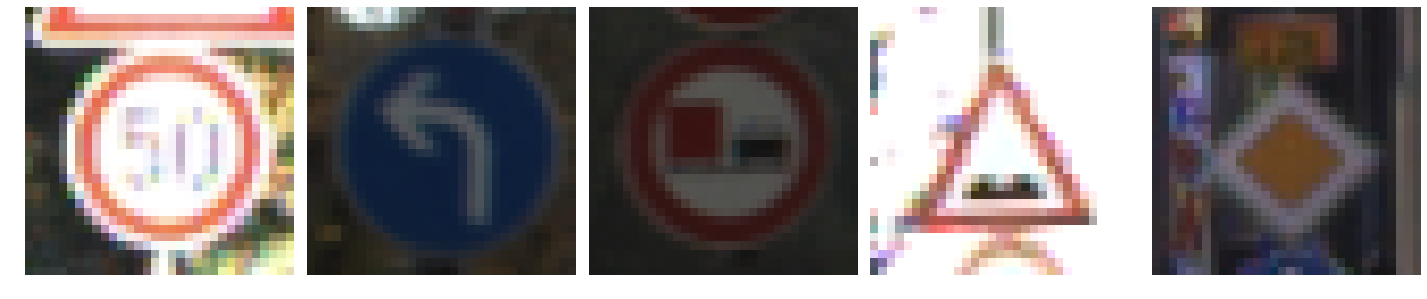

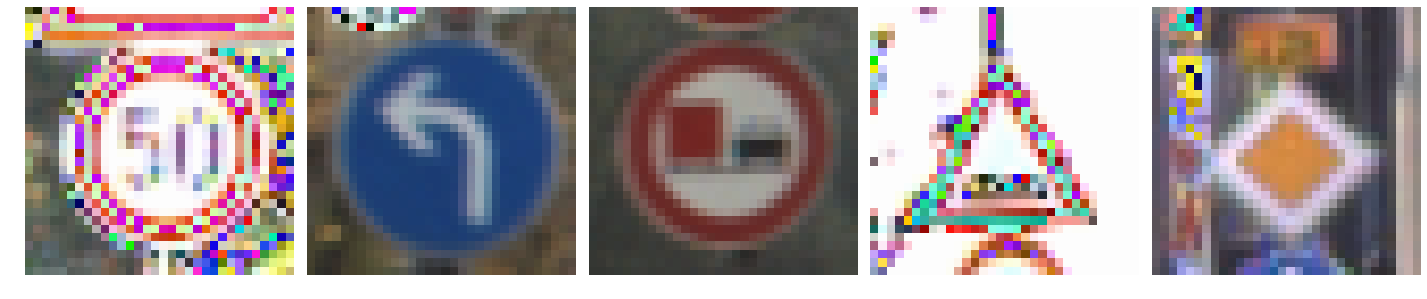

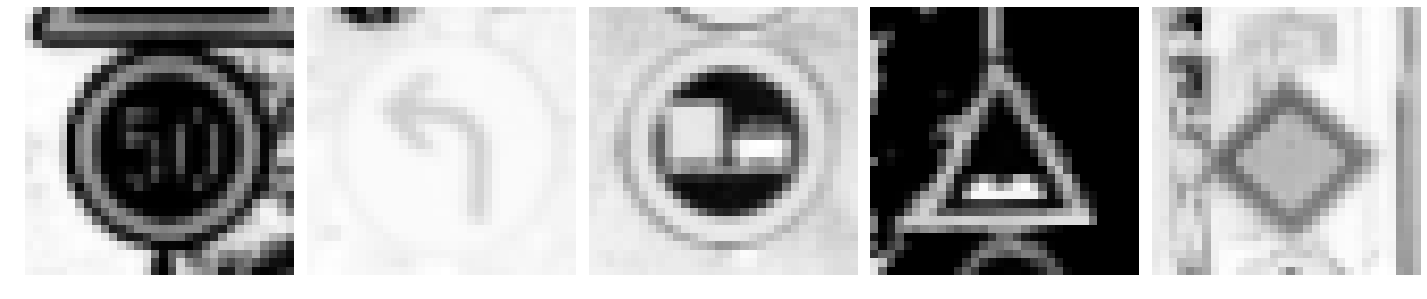

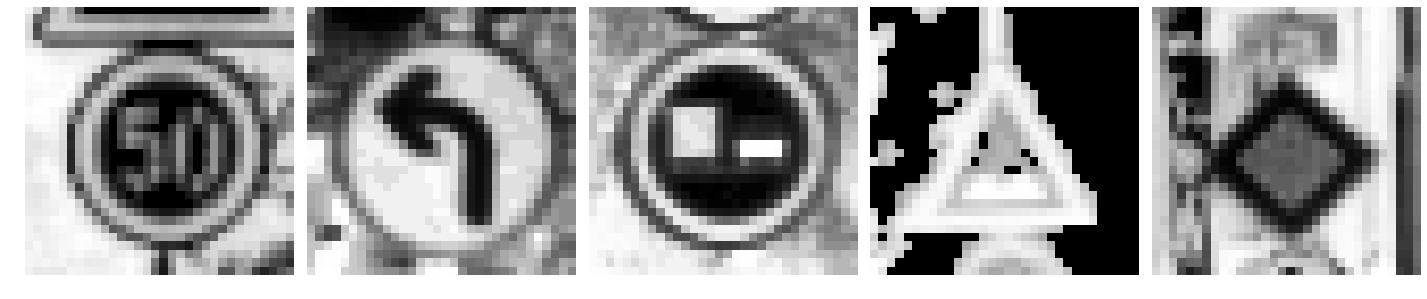

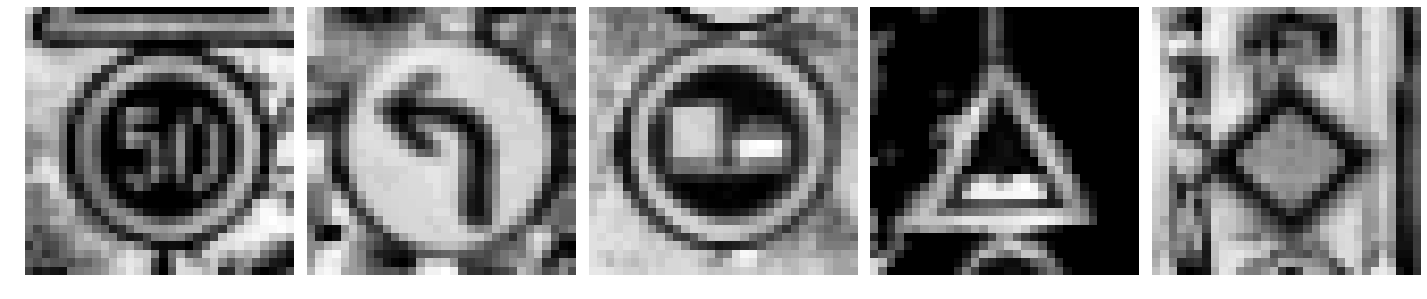

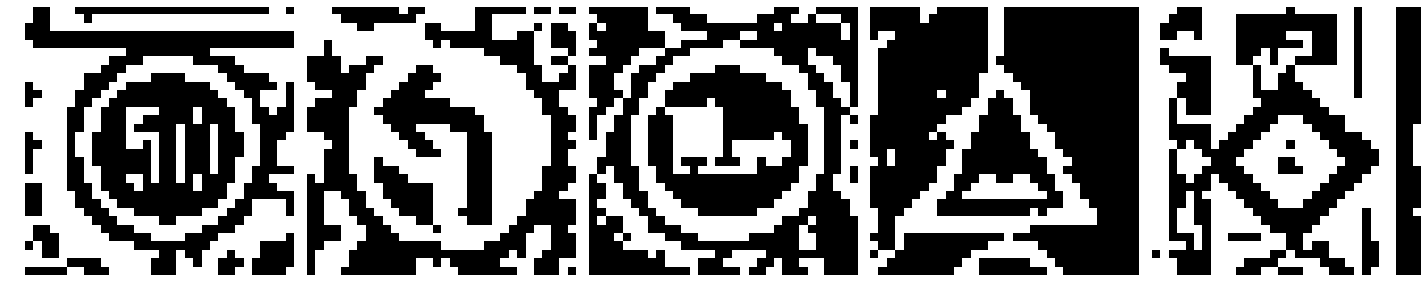

In [11]:
imageset = get_random_image(X_train, 5)
show_all(imageset)
show_all(preprocess(imageset, gray=False))
show_all(preprocess(imageset, gray=True))
show_all(preprocess(imageset, gray=True, equal=True))
show_all(preprocess(imageset, gray=True, adaeq=True))
show_all(preprocess(imageset, gray=True, thresh=True))

# Model Architecture
## Modified Lenet
I tried various modifications.
1. Smaller kernel size: Did not affect accuracy significantly.  
2. Larger network (doubled the number of nodes): Training cost exceeded the level I can afford.
3. Dropout: As there were strong indication of overfitting with vanilla configuration, I added three dropout layers with keep probability of 0.5.

In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def LeNet(x, keep_prob, mu=0, sigma=.1):
    '''
    params: Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    '''  
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')   
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # add dropout
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # add drop out
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    # add drop out
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [13]:
x = tf.placeholder(tf.float32, (None, 32,32,1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [14]:
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:
# batch size for evaluation
BATCH_SIZE = 128

In [16]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
def train_network(x_train, y_train, loss_operation, k_prob=.5, learning_rate=.001, epoch=5, batch_size=128, early_threshold=.0001, save=False, verbose=True):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_operation = optimizer.minimize(loss_operation)    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(x_train)
        
        print("Training...")
        print()
        train_accuracy_log = []
        valid_accuracy_log = []
        last_accuracy = 0
        for i in range(epoch):
            x_train, y_train = shuffle(x_train, y_train)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = x_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: k_prob})
            train_accuracy = evaluate(x_train, y_train)    
            validation_accuracy = evaluate(x_valid, y_valid)

            print("EPOCH {} ...".format(i+1))
            print("Training Accuracy={:.3f}".format(train_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            
            train_accuracy_log.append(train_accuracy)
            valid_accuracy_log.append(validation_accuracy)

            # early stop
            #if abs(validation_accuracy - last_accuracy) < early_threshold:
            #    break
            #last_accuracy = validation_accuracy
        
        if verbose:
            # print learning curve
            epochs = np.arange(1, epoch+1)
            plt.figure(figsize=(7, 7))
            plt.plot(epochs, train_accuracy_log, label='train')
            plt.plot(epochs, valid_accuracy_log, label='validation')
            plt.title('Learning Curve')
            plt.ylabel('accuracy')
            plt.xlabel('epochs')
            plt.xticks(epochs)
            plt.legend(loc='center right')
            
            # print per class accuracy
            pred = sess.run(tf.argmax(logits, 1), feed_dict={x: x_valid, keep_prob: 1.0})
            print(classification_report(y_valid, pred))
        
        if save:
            saver.save(sess, './lenet')
            print("Model saved")

## Affect of preprocessing on validation accuracy
I tested two types of preprocessing, 
1. grayscale, normalization
2. grayscale, adaptive histogram equalizer, normalization.  

I ran them for several iterations by hand. While grayscale with adaptive histogram equalizer performed slight better in few iterations, there were no significant difference in validation accuracy.  
In both cases, validation accuracy passed minimum requirement of .93, but there was a strong sign of overfitting.  
I tested again by lowering keep probability to 0.5, but that negatively affected the accuracy.

Training...

EPOCH 1 ...
Training Accuracy=0.688
Validation Accuracy = 0.657

EPOCH 2 ...
Training Accuracy=0.874
Validation Accuracy = 0.827

EPOCH 3 ...
Training Accuracy=0.928
Validation Accuracy = 0.876

EPOCH 4 ...
Training Accuracy=0.947
Validation Accuracy = 0.895

EPOCH 5 ...
Training Accuracy=0.963
Validation Accuracy = 0.915

EPOCH 6 ...
Training Accuracy=0.970
Validation Accuracy = 0.925

EPOCH 7 ...
Training Accuracy=0.976
Validation Accuracy = 0.935

EPOCH 8 ...
Training Accuracy=0.981
Validation Accuracy = 0.939

EPOCH 9 ...
Training Accuracy=0.984
Validation Accuracy = 0.939

EPOCH 10 ...
Training Accuracy=0.983
Validation Accuracy = 0.938

EPOCH 11 ...
Training Accuracy=0.988
Validation Accuracy = 0.941

EPOCH 12 ...
Training Accuracy=0.989
Validation Accuracy = 0.940

EPOCH 13 ...
Training Accuracy=0.989
Validation Accuracy = 0.939

EPOCH 14 ...
Training Accuracy=0.991
Validation Accuracy = 0.949

EPOCH 15 ...
Training Accuracy=0.990
Validation Accuracy = 0.945

EPOCH 

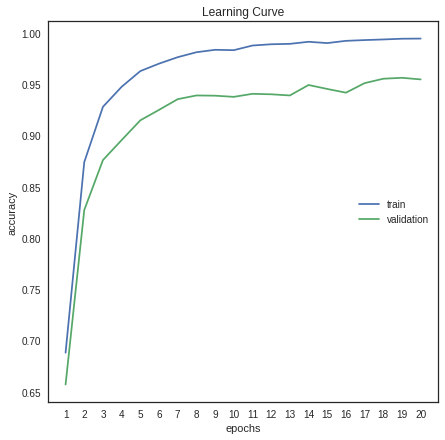

In [18]:
# grayscale only
x_train = preprocess(X_train, gray=True)
x_valid = preprocess(X_valid, gray=True)
x_test = preprocess(X_test, gray=True)
train_network(x_train, y_train, loss_operation, k_prob=.7, epoch=20, save=False)

Training...

EPOCH 1 ...
Training Accuracy=0.833
Validation Accuracy = 0.789

EPOCH 2 ...
Training Accuracy=0.920
Validation Accuracy = 0.872

EPOCH 3 ...
Training Accuracy=0.947
Validation Accuracy = 0.903

EPOCH 4 ...
Training Accuracy=0.969
Validation Accuracy = 0.933

EPOCH 5 ...
Training Accuracy=0.975
Validation Accuracy = 0.941

EPOCH 6 ...
Training Accuracy=0.981
Validation Accuracy = 0.947

EPOCH 7 ...
Training Accuracy=0.985
Validation Accuracy = 0.954

EPOCH 8 ...
Training Accuracy=0.989
Validation Accuracy = 0.961

EPOCH 9 ...
Training Accuracy=0.989
Validation Accuracy = 0.959

EPOCH 10 ...
Training Accuracy=0.991
Validation Accuracy = 0.963

EPOCH 11 ...
Training Accuracy=0.991
Validation Accuracy = 0.960

EPOCH 12 ...
Training Accuracy=0.992
Validation Accuracy = 0.959

EPOCH 13 ...
Training Accuracy=0.993
Validation Accuracy = 0.964

EPOCH 14 ...
Training Accuracy=0.995
Validation Accuracy = 0.965

EPOCH 15 ...
Training Accuracy=0.995
Validation Accuracy = 0.965

EPOCH 

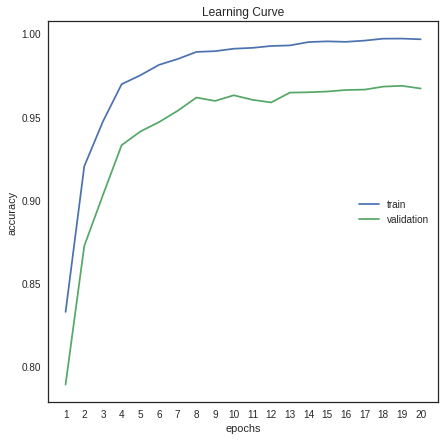

In [19]:
# grayscale and adaptive equalizer
x_train = preprocess(X_train, gray=True, adaeq=True)
x_valid = preprocess(X_valid, gray=True, adaeq=True)
x_test = preprocess(X_test, gray=True, adaeq=True)
train_network(x_train, y_train, loss_operation, k_prob=.7, epoch=20, save=False)

# Final setting
I applied gray scale and adaptive equalizer. I inserted three dropout layers with keep probability of 0.7.
I set learning rate lower to 0.0005 and trained the network for 100 epochs.  
This resulted in validation accuracy of 0.974. However, the network overfitted to training set, reaching 1.0 training accuracy after 70 epochs.  
I set the keep probability to 0.5 to prevent complete overfitting.

Training...

EPOCH 1 ...
Training Accuracy=0.621
Validation Accuracy = 0.579

EPOCH 2 ...
Training Accuracy=0.838
Validation Accuracy = 0.794

EPOCH 3 ...
Training Accuracy=0.890
Validation Accuracy = 0.850

EPOCH 4 ...
Training Accuracy=0.917
Validation Accuracy = 0.873

EPOCH 5 ...
Training Accuracy=0.936
Validation Accuracy = 0.895

EPOCH 6 ...
Training Accuracy=0.945
Validation Accuracy = 0.903

EPOCH 7 ...
Training Accuracy=0.956
Validation Accuracy = 0.916

EPOCH 8 ...
Training Accuracy=0.966
Validation Accuracy = 0.931

EPOCH 9 ...
Training Accuracy=0.971
Validation Accuracy = 0.935

EPOCH 10 ...
Training Accuracy=0.973
Validation Accuracy = 0.938

EPOCH 11 ...
Training Accuracy=0.978
Validation Accuracy = 0.946

EPOCH 12 ...
Training Accuracy=0.980
Validation Accuracy = 0.943

EPOCH 13 ...
Training Accuracy=0.984
Validation Accuracy = 0.949

EPOCH 14 ...
Training Accuracy=0.985
Validation Accuracy = 0.950

EPOCH 15 ...
Training Accuracy=0.988
Validation Accuracy = 0.953

EPOCH 

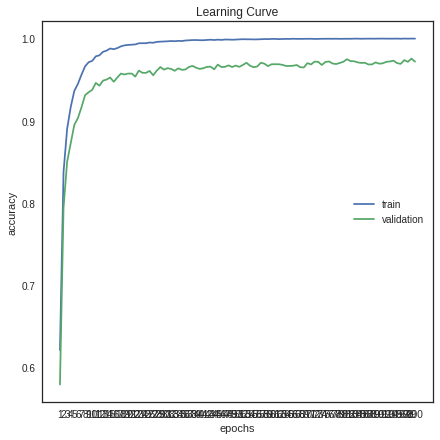

In [22]:
x_train = preprocess(X_train, gray=True, adaeq=True)
x_valid = preprocess(X_valid, gray=True, adaeq=True)
x_test = preprocess(X_test, gray=True, adaeq=True)
train_network(x_train, y_train, loss_operation, epoch=100, k_prob=.7, learning_rate=.0005, save=False)

Training...

EPOCH 1 ...
Training Accuracy=0.458
Validation Accuracy = 0.426

EPOCH 2 ...
Training Accuracy=0.604
Validation Accuracy = 0.555

EPOCH 3 ...
Training Accuracy=0.743
Validation Accuracy = 0.697

EPOCH 4 ...
Training Accuracy=0.823
Validation Accuracy = 0.775

EPOCH 5 ...
Training Accuracy=0.860
Validation Accuracy = 0.817

EPOCH 6 ...
Training Accuracy=0.878
Validation Accuracy = 0.840

EPOCH 7 ...
Training Accuracy=0.899
Validation Accuracy = 0.849

EPOCH 8 ...
Training Accuracy=0.908
Validation Accuracy = 0.860

EPOCH 9 ...
Training Accuracy=0.918
Validation Accuracy = 0.868

EPOCH 10 ...
Training Accuracy=0.929
Validation Accuracy = 0.884

EPOCH 11 ...
Training Accuracy=0.935
Validation Accuracy = 0.888

EPOCH 12 ...
Training Accuracy=0.939
Validation Accuracy = 0.895

EPOCH 13 ...
Training Accuracy=0.951
Validation Accuracy = 0.902

EPOCH 14 ...
Training Accuracy=0.950
Validation Accuracy = 0.907

EPOCH 15 ...
Training Accuracy=0.953
Validation Accuracy = 0.907

EPOCH 

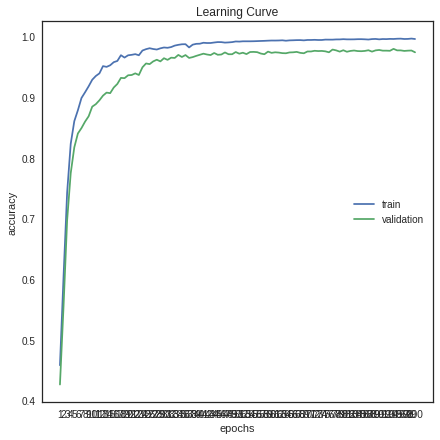

In [23]:
x_train = preprocess(X_train, gray=True, adaeq=True)
x_valid = preprocess(X_valid, gray=True, adaeq=True)
x_test = preprocess(X_test, gray=True, adaeq=True)
train_network(x_train, y_train, loss_operation, epoch=100, k_prob=.5, learning_rate=.0005, save=True)

In [24]:
# test image
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(x_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.962


# Result observation
The class with lowest validation accuracy were 16 (acc=.55, n=60). 
Let's see what confused the network.

In [47]:
from scipy.stats import itemfreq

def chk_prediction(class_num):
    xgrp = x_valid[y_valid==class_num]
    kv2 = None
    softmax_logits = tf.nn.softmax(logits)
    top_k = tf.nn.top_k(softmax_logits, k=5)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, './lenet')    
        pred = sess.run(softmax_logits, feed_dict={x: xgrp, keep_prob: 1.0})
        kv2 = sess.run(tf.nn.top_k(pred, k=5))
    pred_y = np.array([i[0] for i in kv2.indices])
    print(itemfreq(pred_y))

In [60]:
from collections import Counter

print('class 16 prediction count:')
chk_prediction(16)
count = Counter(y_train)
print('Number of samples 16: {}  41: {}'.format(count[16], count[41]))

class 16 prediction count:
[[16 33]
 [32  3]
 [41 24]]
Number of samples 16: 360  41: 210


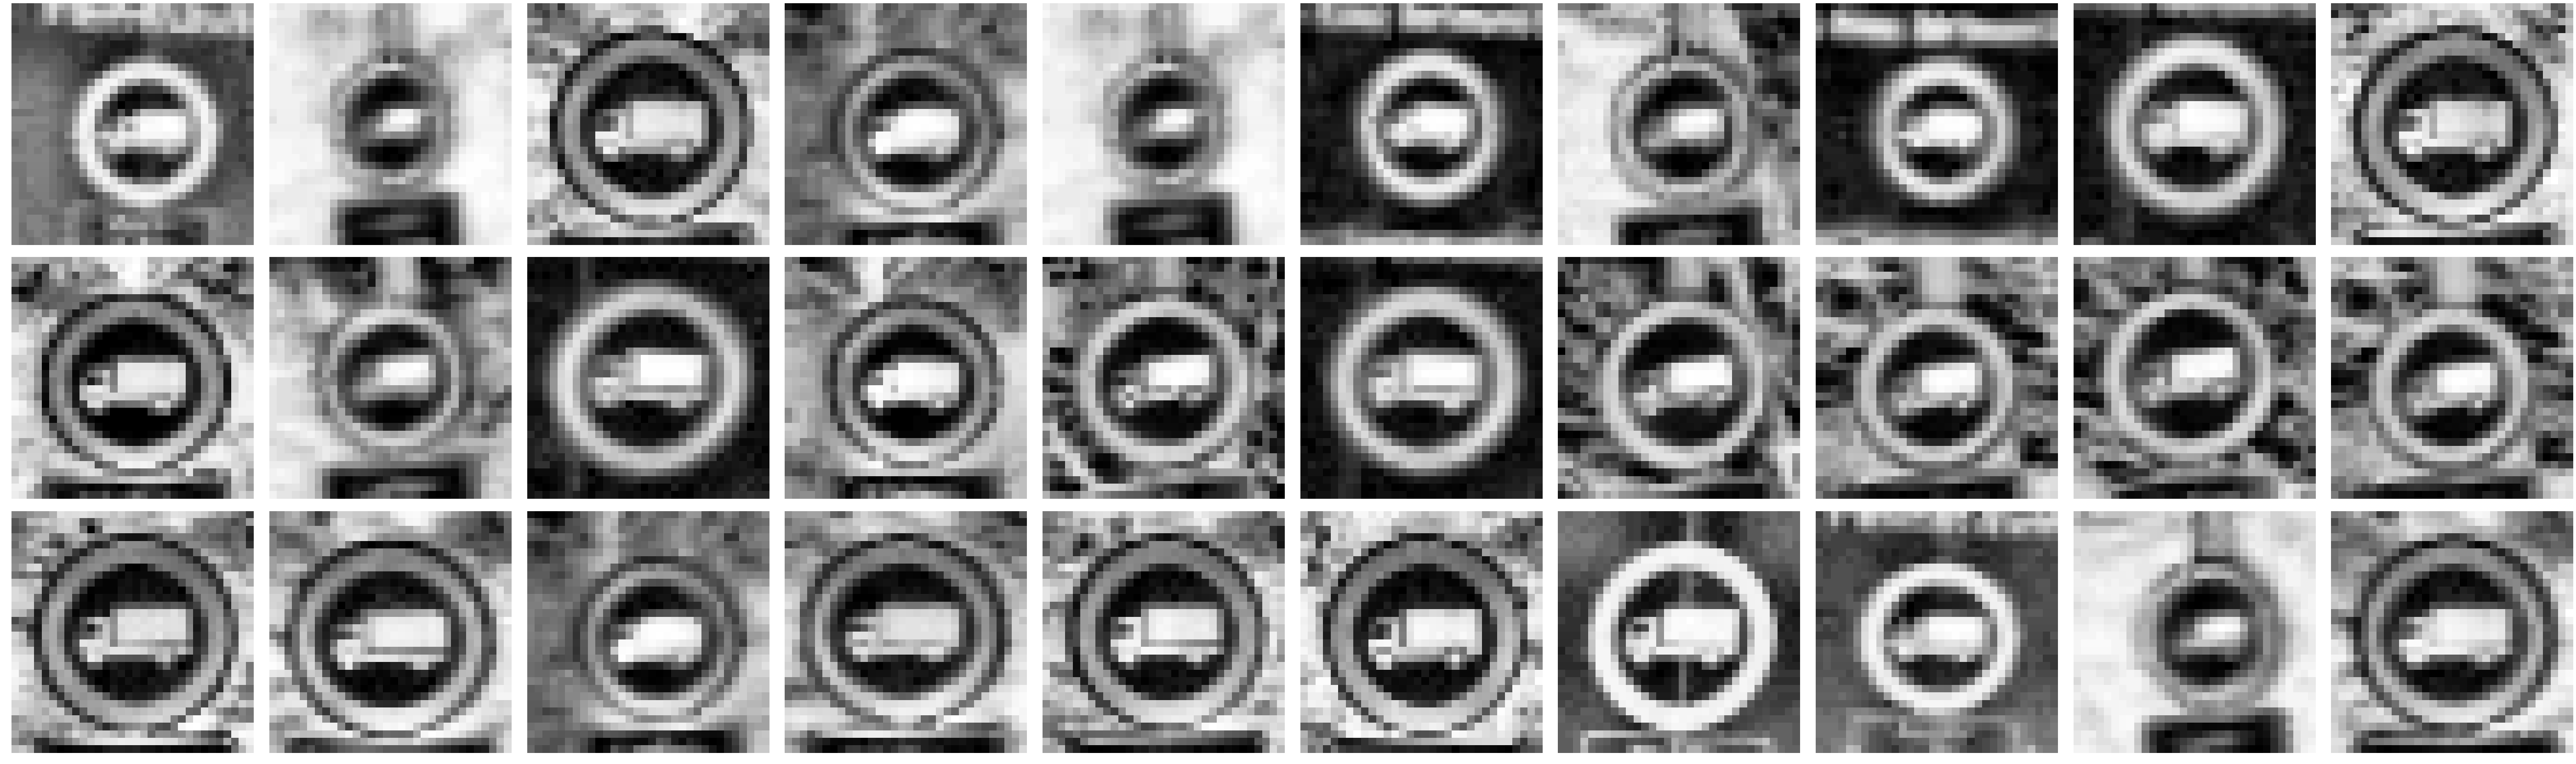

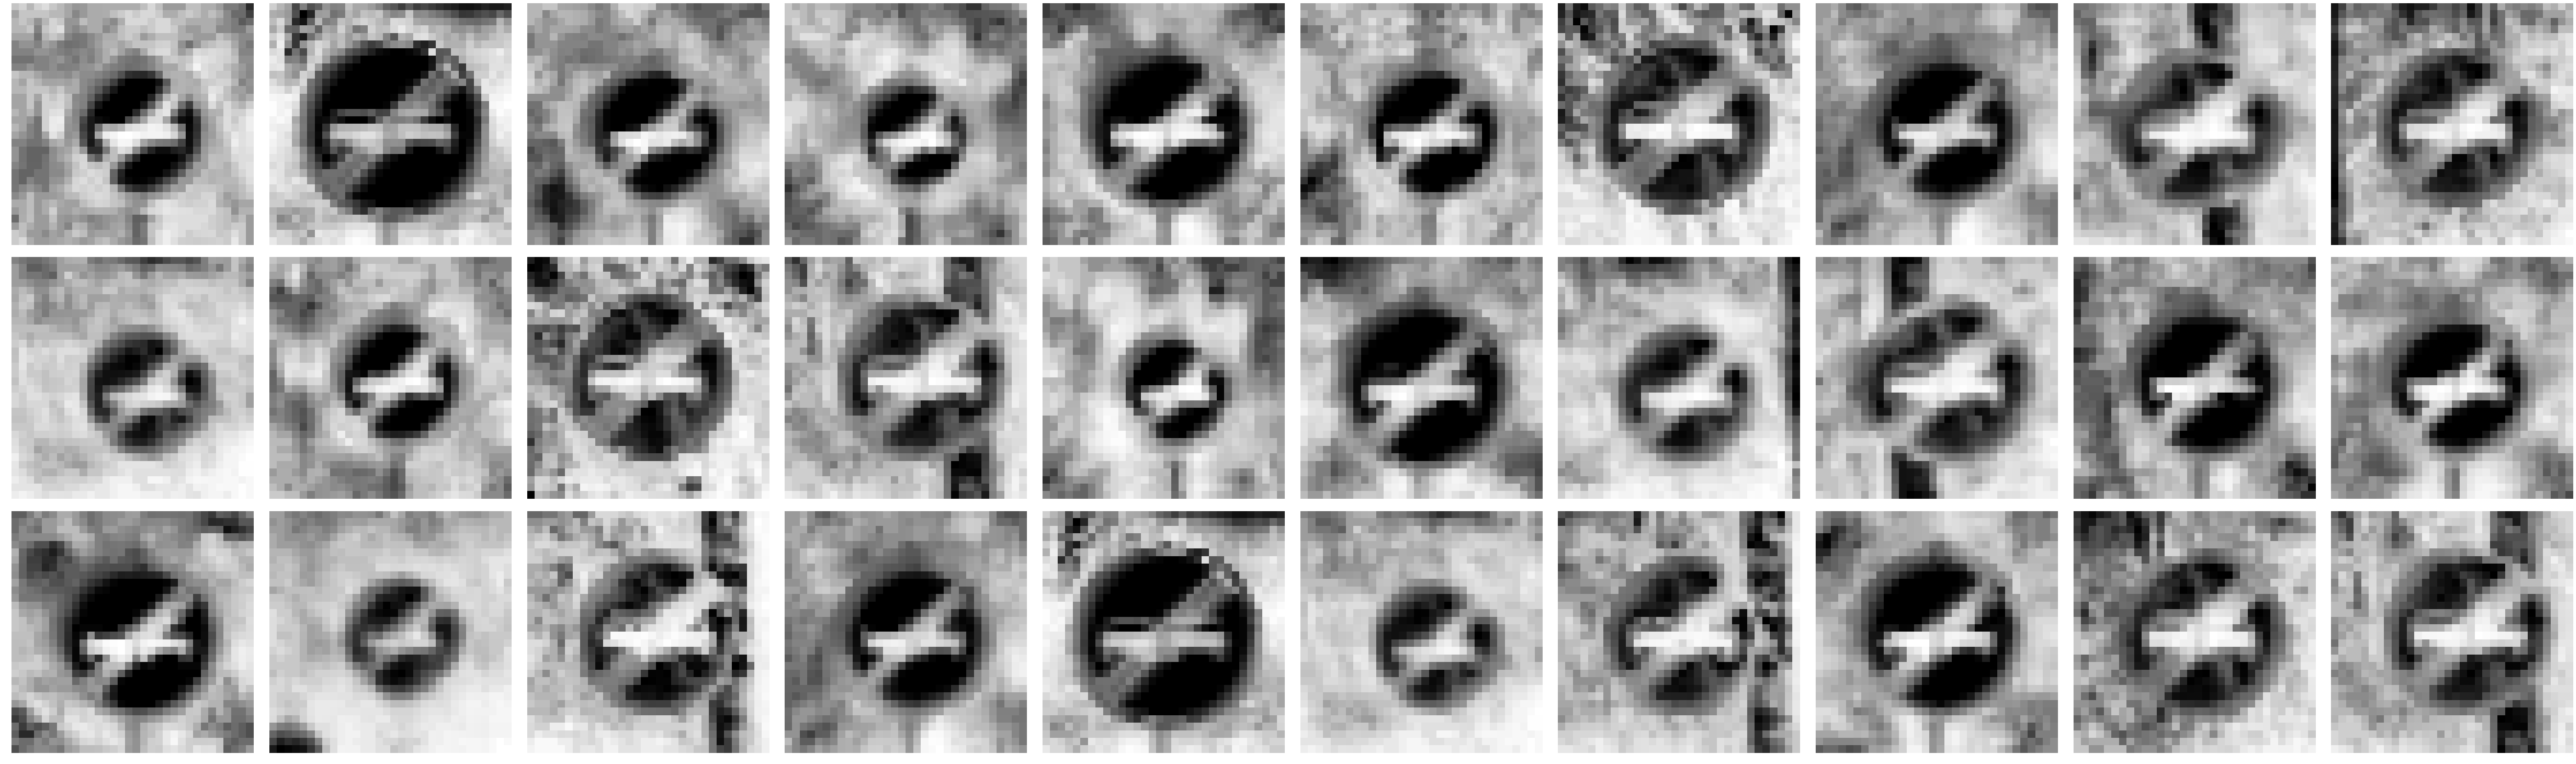

In [54]:
show_class(x_test, y_test, 16, 30)
show_class(x_test, y_test, 41, 30)

The truck sign (class 16) was concfused as class 41 sign. There seems to be noticable difference between samples.  
From the precision scores, we can see that lots of samples from other classes are being misidentified as class 41.  
There is some room for improvement for the network. I'll try to fine tune it when I get some more free time.  
Both classes have small sample size, so adding more samples may improve the result.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

## Preprocessing new images
I collected 5 images from web. The images include watermark, not square, and the position of  
some of the signs are off-center. I added modified version for the images that was originally classified incorrectly (cropped and translated signs to center).

### Load and Output the Images

In [26]:
import os
from os import listdir
# load files from path and preprocess
def preprocess_image_path(path):
    image = np.ndarray((len(os.listdir(path)), 32, 32, 3), dtype=float) 
    new_y = []    
    num = len(os.listdir(path))
    plt.figure(figsize=(9, 3*int(np.ceil(num/3))))
    for i, file in enumerate(sorted(os.listdir(path))):
        new_y.append(int(file.split('.')[0]))
        img = cv2.imread(path + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
        #img = cv2.copyMakeBorder(img, top=5, bottom=5, left=5, right=5, \
        #                  borderType= cv2.BORDER_CONSTANT, value=[0,0,0] )
        img = cv2.GaussianBlur(img, (3,3), 0)
        
        plt.subplot(np.ceil(num/3), 3, i+1)
        plt.axis('off')        
        plt.imshow(img)        
        image[i] = img
    return preprocess(np.array(image),gray=True, adaeq=True), new_y

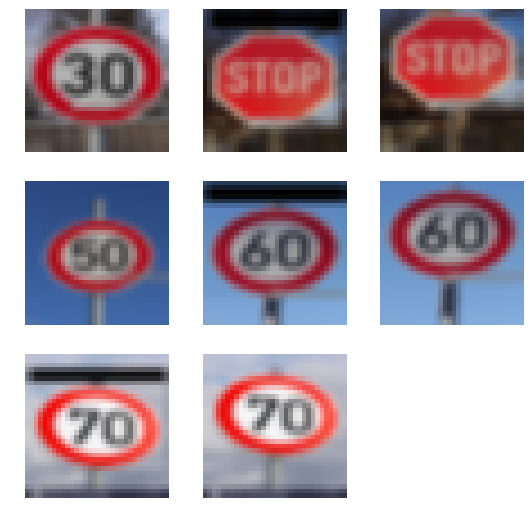

In [27]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
new_image, new_y = preprocess_image_path('./signs/')

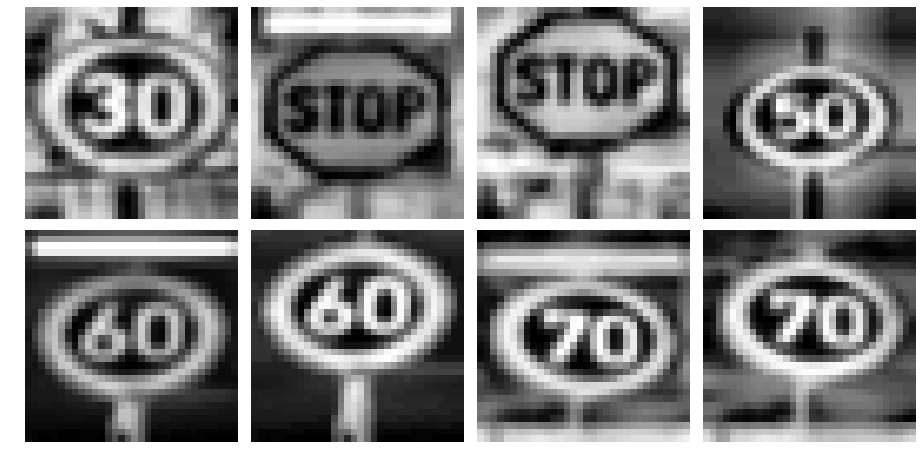

In [28]:
show_all(new_image, 4)

In [29]:
print(new_y)

[1, 14, 14, 2, 3, 3, 4, 4]


### Predict the Sign Type for Each Image

In [30]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
kv2 = None
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')    
    pred = sess.run(softmax_logits, feed_dict={x: new_image, keep_prob: 1.0})
    kv2 = sess.run(tf.nn.top_k(pred, k=5))
pred_y = np.array([i[0] for i in kv2.indices])
print(pred_y)

[ 1 14  9  2  3 17  4  1]


### Analyze Performance

In [31]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
accuracy_score(pred_y, new_y)

0.625

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [32]:
sns.set_style("white", {'axes.grid':False})

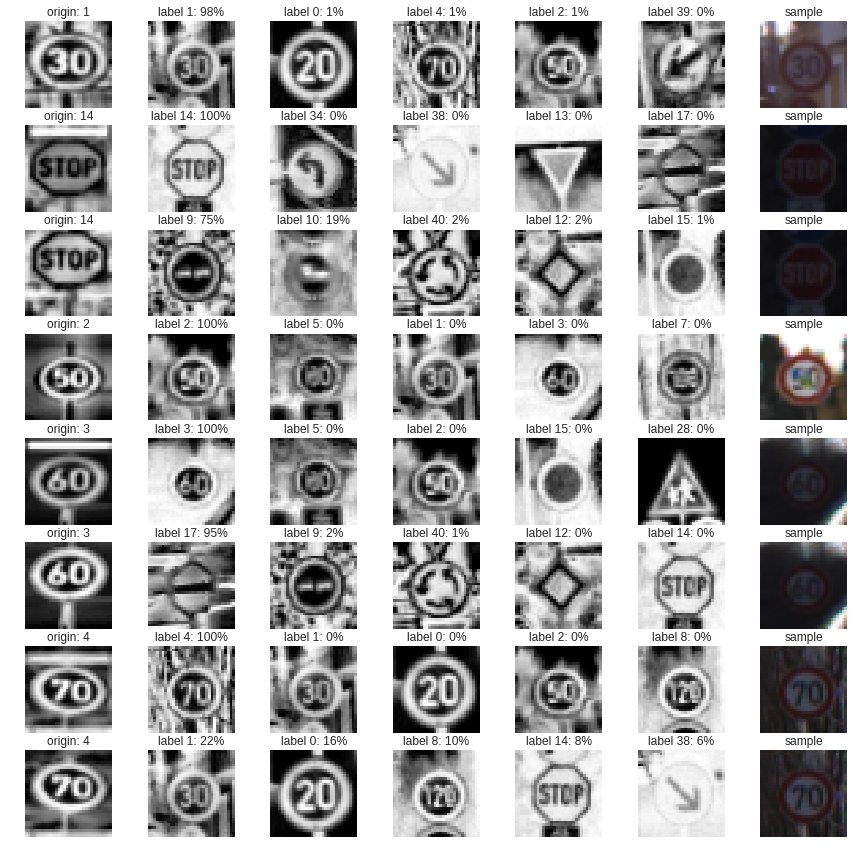

In [33]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
figure = plt.figure(figsize=(15,15))
for i, img in enumerate(new_image):
    row = new_image.shape[0]
    plt.subplot(row, 7, 7*i+1)
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.title('origin: {}'.format(new_y[i]))
    
    index = kv2.indices[i]
    per = kv2.values[i]
    j = 2
    for ind, p in zip(index, per):
        plt.subplot(row, 7, 7*i + j)
        plt.axis('off')
        plt.imshow((x_train[y_train==ind][5].squeeze()))
        plt.title('label {}: {:.0f}%'.format(ind, p*100))        
        j += 1
    
    plt.subplot(row, 7, 7*(i+1))
    plt.axis('off')
    plt.imshow((X_train[y_train==new_y[i]][5].squeeze()))
    plt.title('sample')     
        
#plt.tight_layout()

## The result
After moving the signs to the center of the image, the classifier predicted all 5 samples correctly, where as it predicted only 2 correctly before the modification. The position of the sign seems to be a critical feature for the classifier. The training set included augmented samples but would benefit by adding more samples with extreme translation.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

In [34]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

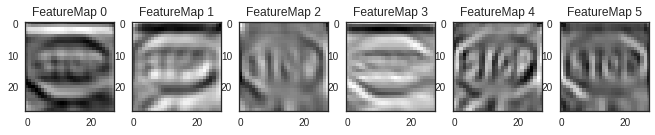

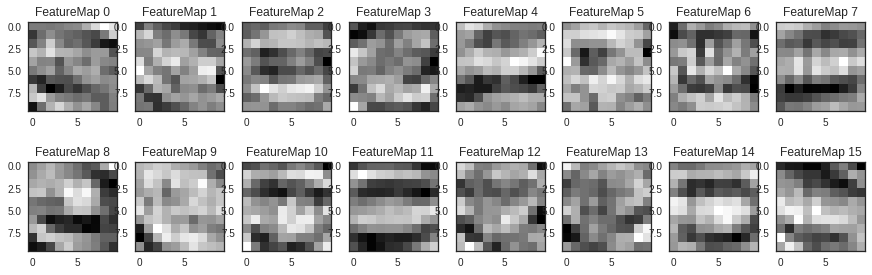

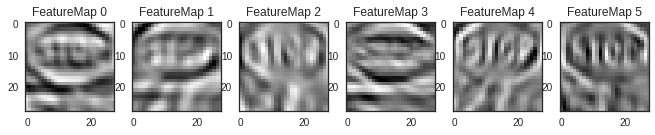

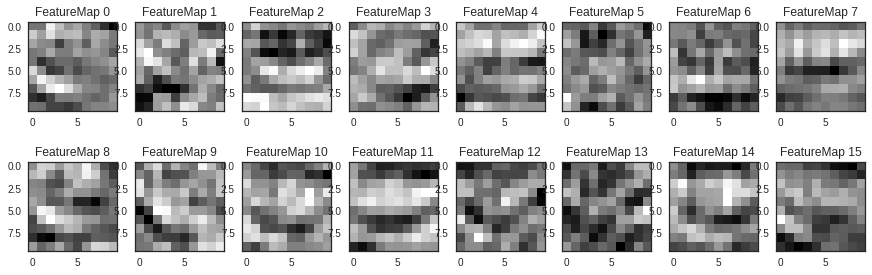

In [36]:
with tf.Session() as sess:
    tf_saver = tf.train.Saver()
    saver.restore(sess, './lenet')
    op = sess.graph.get_operations()
    conv = tf.get_default_graph().get_tensor_by_name('Conv2D:0')
    outputFeatureMap(new_image[1:5], conv, plt_num=1)
    conv = tf.get_default_graph().get_tensor_by_name('Conv2D_1:0')
    outputFeatureMap(new_image[1:5], conv, plt_num=2)
    
    conv = tf.get_default_graph().get_tensor_by_name('Conv2D:0')
    outputFeatureMap(new_image[2:5], conv, plt_num=3)
    conv = tf.get_default_graph().get_tensor_by_name('Conv2D_1:0')
    outputFeatureMap(new_image[2:5], conv, plt_num=4)

# Comparing feature maps
I compared two stop sign images. The first image is an augmented image of the second one. THe first image was classified correctly, whereas the first image was not.     
The feature maps of conv1 layer shows same patterns except for the position of the sign. As for the feature maps of conv2 layer, some of the maps do seems exhibit difference patterns, but it is unclear to what extent these maps contributed to the difference in prediction. However, featuremap of conv layer1 shows that the network is able to extract critical aspects of the signs, for example edge and letters.